# Multi-Class Text Classification
There are lots of applications of text classification in the commercial world.
For example, news stories are typically organized by topics;content or products are often tagged by catogiries;users can be classified into cohorts based on how they talk about a product or brand online....

Step1-Load

In [ ]:
import pandas as pd 
df=pd.read_csv('/home/pranita/PRANITA/M.Tech(CDAC)/ML/files/Consumer_Complaints.csv')


In [2]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/14/2019,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",NC,27519,NaN,Consent not provided,Web,03/14/2019,Closed with explanation,Yes,NaN,3179505.0
1,03/14/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CURO Intermediate Holdings,AZ,85040,NaN,NaN,Web,03/14/2019,Closed with explanation,Yes,NaN,3179861.0
2,03/14/2019,Vehicle loan or lease,Loan,Problem with a credit reporting company's inve...,Problem with personal statement of dispute,NaN,NaN,ALLY FINANCIAL INC.,MS,397XX,NaN,NaN,Web,03/14/2019,In progress,Yes,NaN,3179198.0
3,03/14/2019,Vehicle loan or lease,Loan,Improper use of your report,Reporting company used your report improperly,NaN,NaN,ALLY FINANCIAL INC.,MI,484XX,NaN,NaN,Referral,03/14/2019,In progress,Yes,NaN,3179501.0
4,03/14/2019,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,Bonneville Billing and Collections,FL,330XX,NaN,NaN,Web,03/14/2019,Closed with explanation,Yes,NaN,3179976.0


step2- Input Output Extraction

In [3]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
# Non null values Extraction
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
# TO categorize the particular products.
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
5225,Debt collection,I have repeatedly tried to have company verify...,0
5552,Debt collection,Perfection Collection XXXX XXXX XXXX XXXX XXXX...,0
5761,Debt collection,ability recovery services had put a collection...,0
5814,"Credit reporting, credit repair services, or o...",My credit report showed me a hard inquiry made...,1
6289,Debt collection,XXXX XXXX XXXX is reporting a collection for X...,0


In [4]:
df['Product'].unique()

array(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Checking or savings account', 'Student loan',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Payday loan, title loan, or personal loan',
       'Money transfer, virtual currency, or money service'], dtype=object)

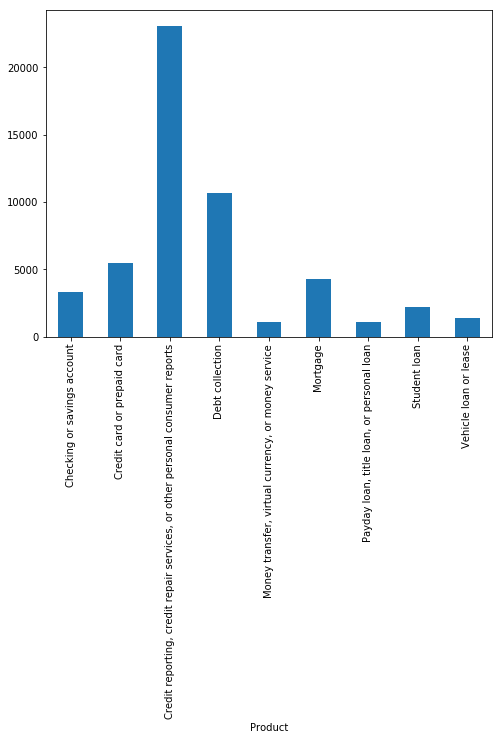

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')

In [7]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [8]:
features = tfidf.fit_transform(df.Consumer_complaint_narrative)

In [9]:
labels = df.category_id
features.shape

(52529, 131712)

In [ ]:
# chi-square measures dependence between stochastic variables, so using this function "weeds out" the features that are the most likely to be independent of class and therefore irrelevant for classification
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # "This is a multitext classification"
    # unigram- "This","is","a","multitext","classification"
    # bigram- "This is", "a multitext", "classification"
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print(" , Most correlated unigrams:\n. {}".format('\n.'.join(unigrams[-N:])))
    print(" , Most correlated bigrams:\n. {}".format('\n.'.join(unigrams[-N:])))

# # MultiNomial NB

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [15]:
X_train,X_test,y_train,y_test=train_test_split(df['Consumer_complaint_narrative'],df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
print(clf.predict(count_vect.transform(["I have repeatedly tried to have company verify..."])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [22]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [20]:
model = LinearSVC()
X_train,X_test,y_train,y_test,indices_train,indices_test=train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 4, 1], dtype=int64)

In [24]:
accuracy_score = model.score(X_test,y_test)
accuracy_score

0.8633977502163254

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
confusion_matrix

array([[2907,  371,   29,   29,   60,   45,   32,   15,    8],
       [ 279, 7115,   15,   26,   97,   28,   32,    5,    4],
       [  17,   24,  922,    0,   79,    6,    2,    2,   29],
       [  43,   68,    1,  589,    6,    9,    1,    7,    0],
       [  74,  199,   62,    4, 1482,    9,    5,    2,   10],
       [  25,   53,   11,   12,   14, 1321,    4,    3,    2],
       [  48,  105,    5,    6,   21,   17,  256,    5,    1],
       [  75,   30,   12,   12,   18,   14,    6,  157,    4],
       [  11,   11,   83,    1,   22,    3,    0,    0,  218]],
      dtype=int64)

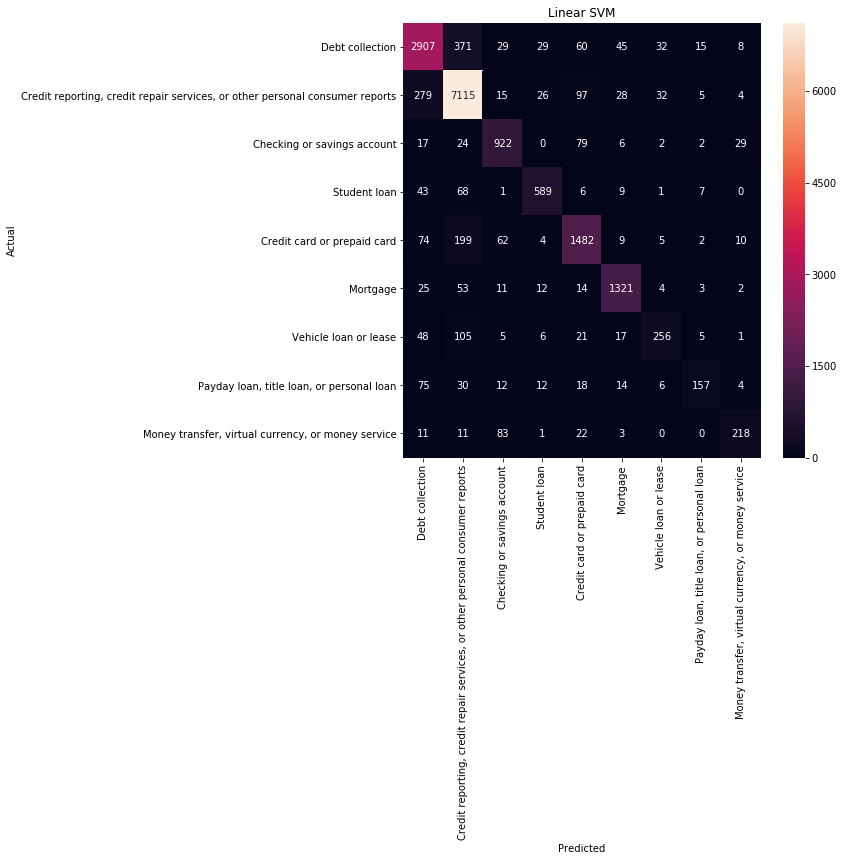

In [32]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear SVM')
plt.show()